# Example for SoftwareX paper

### M.Ravasi

This example is a slightly modified version of the Solvers tutorial at https://pylops.readthedocs.io/en/latest/tutorials/solvers.html#sphx-glr-tutorials-solvers-py.

We will go through the creation of some linear operators and the solution of an inverse problem. The problem that we are going to consider is generally referred to
as the *data reconstruction* problem and aims at reconstructing a regularly
sampled signal of size $M$ from $N$ randomly selected samples:

\begin{align}\mathbf{y} = \mathbf{R} \mathbf{x}\end{align}

where the restriction operator $\mathbf{R}$ that selects the $M$
elements from $\mathbf{x}$ at random locations is implemented using `pylops.Restriction`, and

\begin{align}\mathbf{y}= [y_1, y_2,...,y_N]^T, \qquad
    \mathbf{x}= [x_1, x_2,...,x_M]^T, \qquad\end{align}

with $M>>N$.

In [1]:
%matplotlib inline

# pylint: disable=C0103
import numpy as np
import matplotlib.pyplot as plt

import pylops

plt.close('all')
np.random.seed(10)

Let's first create the data in the frequency domain. The data is composed
by the superposition of 3 sinusoids with different frequencies. We then use the `pylops.FFT` operator to obtain the time domain version of the signal.

In [2]:
# input signal parameters
ifreqs = [41, 25, 66]
amps = [1., 1., 1.]
nt = 200
nfft = 2**11
dt = 0.004
t = np.arange(nt)*dt
f = np.fft.rfftfreq(nfft, dt)

# input signal in frequency domain
X = np.zeros(nfft//2+1, dtype='complex128')
X[ifreqs] = amps

# input signal in time domain
FFTop = pylops.signalprocessing.FFT(nt, nfft=nfft, real=True)
x = FFTop.H * X

We now define the locations at which the signal will be sampled, apply forward, adjoint and inverse

In [3]:
# sampling locations    
perc_subsampling = 0.2
ntsub = int(np.round(nt*perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(nt))[:ntsub])

# create operator
Rop = pylops.Restriction(nt, iava, dtype='float64')

# apply forward
y = Rop * x
ymask = Rop.mask(x)

# apply adjoint
xadj = Rop.H * y

# apply inverse
xinv = Rop / y

(0, 0.8)

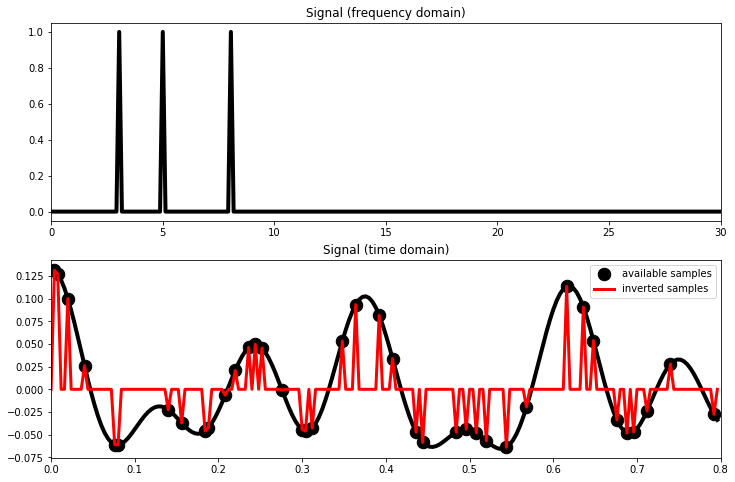

In [4]:
# Visualize data
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].plot(f, np.abs(X), 'k', lw=4)
axs[0].set_xlim(0, 30)
axs[0].set_title('Signal (frequency domain)')
axs[1].plot(t, x, 'k', lw=4)
axs[1].plot(t, ymask, '.k', ms=25, label='available samples')
axs[1].plot(t, xinv, 'r', lw=3, label='inverted samples')
axs[1].legend()
axs[1].set_title('Signal (time domain)')
axs[1].set_xlim(0, 0.8)

Finally can use more advanced solvers such as `pylops.optimization.leastsquares.RegularizedInversion` and 
`pylops.optimization.sparsity.FISTA` to improve the solution.

In [5]:
# regularized inversion
D2op = pylops.SecondDerivative(nt, dims=None, dtype='float64')

epsR = np.sqrt(0.1)
epsI = np.sqrt(1e-4)

xne = \
    pylops.optimization.leastsquares.NormalEquationsInversion(
    Rop, [D2op], y, epsI=epsI, epsRs=[epsR], returninfo=False,
    **dict(maxiter=50))

# sparse inversion
pfista, niterf, costf = \
    pylops.optimization.sparsity.FISTA(
    Rop*FFTop.H, y, niter=1000, eps=0.001, tol=1e-7, returninfo=True)
xfista = FFTop.H*pfista

And we visualize the various interpolated signals

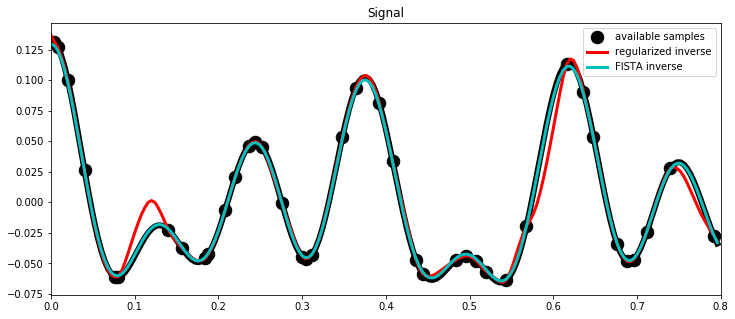

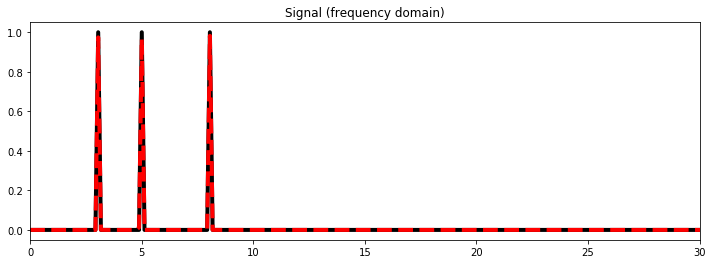

In [6]:
# Visualize data
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(t, x, 'k', lw=6)
ax.plot(t, ymask, '.k', ms=25, label='available samples')
ax.plot(t, xne, 'r', lw=3, label='regularized inverse')
ax.plot(t, xfista, 'c', lw=3, label='FISTA inverse')
ax.legend()
ax.set_title('Signal')
ax.set_xlim(0, 0.8)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(f, np.abs(X), 'k', lw=4, label='original')
ax.plot(f, np.abs(pfista), '--r', lw=4, label='FISTA')
ax.set_xlim(0, 30)
ax.set_title('Signal (frequency domain)');